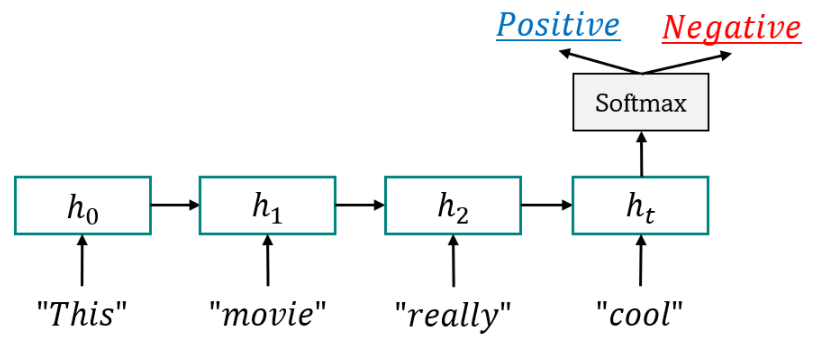

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

#자연어 데이터 처리를 위해서 torchtext 임포트
#if torchtext가 0.9.0 버전 이상이면(colab)
from torchtext.legacy import data, datasets 

#elif torchtext가 0.8.0 버전 이하면 
#from torchtext import data, datasets


In [3]:
# 하이퍼파라미터 정의
BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")#GPU, CPU
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cuda


In [4]:
# 데이터 로딩하기
print("데이터 로딩중...")

# data.Field 설명 #
# sequential인자 : TEXT는 Sequential 데이터라 True, Lable은 비Sequential이라 False로 설정
# batch_first : Batch를 우선시 하여, Tensor 크기를 (BATCH_SIZE, 문장의 최대 길이)로 설정
# lower : 소문자 전환 인자
# # # # # # # # # #
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.Field(sequential=False, batch_first=True)

#IMDB 데이터 로딩
trainset, testset = datasets.IMDB.splits(TEXT, LABEL)

# data.Field.build_vocab() 라이브러리
# 문장 내 단어와 Integer index 를 매칭시키는 단어장(vocab)을 생성 == 워드 임베딩을 위한 Vocab 생성
# <UNK> = 0, <PAD> = 1 토큰도 추가.
# min_freq : 최소 5번 이상 등장한 단어들만 사전에 담겠다는 것. 
# 5번 미만으로 등장하는 단어는 UNK라는 토큰으로 대체
TEXT.build_vocab(trainset, min_freq=5)# TEXT 데이터를 기반으로 Vocab 생성
LABEL.build_vocab(trainset)# LABEL 데이터를 기반으로 Vocab 생성


# 학습용 데이터를 학습셋 80% 검증셋 20% 로 나누기
trainset, valset = trainset.split(split_ratio=0.8)
# 매 배치마다 비슷한 길이에 맞춰 줄 수 있도록 iterator 정의
train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False)


vocab_size = len(TEXT.vocab)
n_classes = 2 
# Positive, Negative Class가 두 개

'''
# Test #
for batch in train_iter:
    print(batch.text)
    print(batch.label)
    break
'''     

데이터 로딩중...
downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:07<00:00, 11.0MB/s]


'\n# Test #\nfor batch in train_iter:\n    print(batch.text)\n    print(batch.label)\n    break\n'

In [5]:
print("[학습셋]: %d [검증셋]: %d [테스트셋]: %d [단어수]: %d [클래스] %d"
      % (len(trainset),len(valset), len(testset), vocab_size, n_classes))

[학습셋]: 20000 [검증셋]: 5000 [테스트셋]: 25000 [단어수]: 46159 [클래스] 2


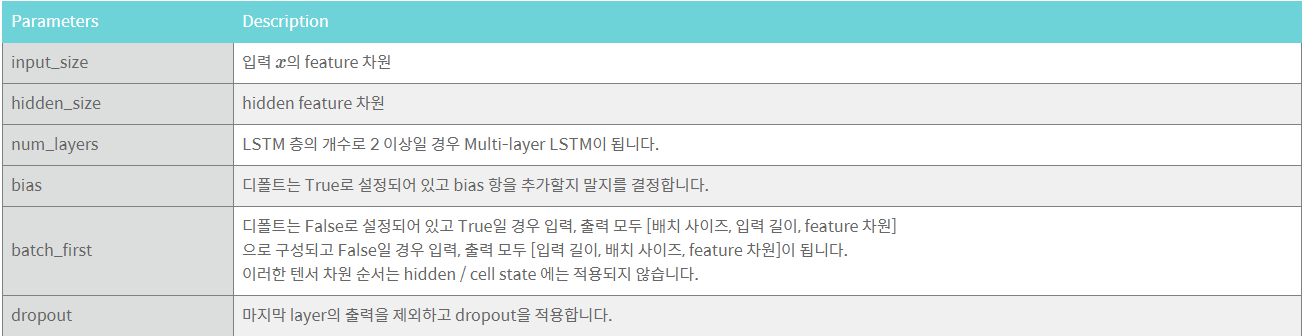

출처 : https://hongl.tistory.com/247

# 여기부터 과제 시작

In [22]:
class BasicLSTM(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes):
        super(BasicLSTM, self).__init__()
        print("Building Basic LSTM model...")

        
        self.n_layers = n_layers 
        #n_vocab : Vocab 안에 있는 단어의 개수, embed_dim : 임베딩 된 단어 텐서가 갖는 차원 값(dimension)
        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.hidden_dim = hidden_dim
#---------------------------------------------- 여기 밑부터 작성해주세요~-------------------------------------------------
        #앞에서 정의한 하이퍼 파라미터를 넣어 LSTM 정의
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        
        #Input: LSTM의 hidden state vector(context), Output : Class probability vector
        self.out = nn.Linear(hidden_dim, n_classes)
#----------------------------------------------여기까지-------------------------------------------------

    def forward(self, x):
        # Input data: 한 batch 내 모든 영화 평가 데이터
        
        x = self.embed(x)# 영화 평 임베딩

        # 초기 hidden, cell state vector를 zero vector로 생성
        h_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim)).to(DEVICE)
        c_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim)).to(DEVICE)
#------------------------------------------------여기 밑부터 작성해주세요-------------------------------------------------------------
        output, (h_t, c_t) = self.lstm(x, (h_0, c_0))
        #print(h_t.shape)
        #(1,64,h) ==> 64 batch-size,  h hidden_dimmension

        # 영화 리뷰 배열들을 압축한 hidden state vector
        # (batch_size, hidden_dim)형태의 텐서 추출
        h_t = h_t.view(-1, self.hidden_dim)

#-------------------------------------------------여기까지---------------------------------------------------------
        # linear layer의 입력으로 주고, 각 클래스 별 결과 logit을 생성.
        logit = self.out(h_t)  # [b, h] -> [b, o]
        return logit


In [23]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)  # 레이블 값을 (기존 1, 2)에서 0과 1로 변환
        optimizer.zero_grad()# 매번 기울기를 새로 계산하기 위해서 zero 로 초기화
        logit = model(x)#모델의 예측값 logit 계산
        #print(y)
        loss = F.cross_entropy(logit, y)# logit과 실제 label간의 오차를 구하고 기울기 계산
        loss.backward()
        optimizer.step()

In [24]:
def evaluate(model, val_iter):
    """evaluate model"""                   
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:# Validation 데이터셋에 대하여 
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1) # 레이블 값을 0과 1로 변환
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    #전체 validation 셋에 대한 평균 loss와 accuracy를 구하는 과정
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

참고 : __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes):

In [25]:
model = BasicLSTM(1, 32, vocab_size, 128, n_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Building Basic LSTM model...


In [26]:
model

BasicLSTM(
  (embed): Embedding(46159, 128)
  (lstm): LSTM(128, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

In [27]:
best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[이폭: %d] 검증 오차:%5.2f | 검증 정확도:%5.2f" % (e, val_loss, val_accuracy))
    
    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

[이폭: 1] 검증 오차: 0.69 | 검증 정확도:51.70
[이폭: 2] 검증 오차: 0.69 | 검증 정확도:49.46
[이폭: 3] 검증 오차: 0.70 | 검증 정확도:49.88
[이폭: 4] 검증 오차: 0.70 | 검증 정확도:50.74
[이폭: 5] 검증 오차: 0.70 | 검증 정확도:51.60
[이폭: 6] 검증 오차: 0.70 | 검증 정확도:52.66
[이폭: 7] 검증 오차: 0.66 | 검증 정확도:66.58
[이폭: 8] 검증 오차: 0.57 | 검증 정확도:72.78
[이폭: 9] 검증 오차: 0.65 | 검증 정확도:66.74
[이폭: 10] 검증 오차: 0.57 | 검증 정확도:75.98


In [28]:
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss, test_acc = evaluate(model, test_iter)
print('테스트 오차: %5.2f | 테스트 정확도: %5.2f' % (test_loss, test_acc))

테스트 오차:  0.57 | 테스트 정확도: 73.44


# 추가과제 
1. GRU가 무엇인지, 장점 단점을 한페이지 이내로 조사 해오기 :)
+) hidden_dim, epoch 등등 hyperparameter을 잘 지지고 볶고, 할줄 아는 기법들 다 섞어서 최고의 LSTM 만들어오기!


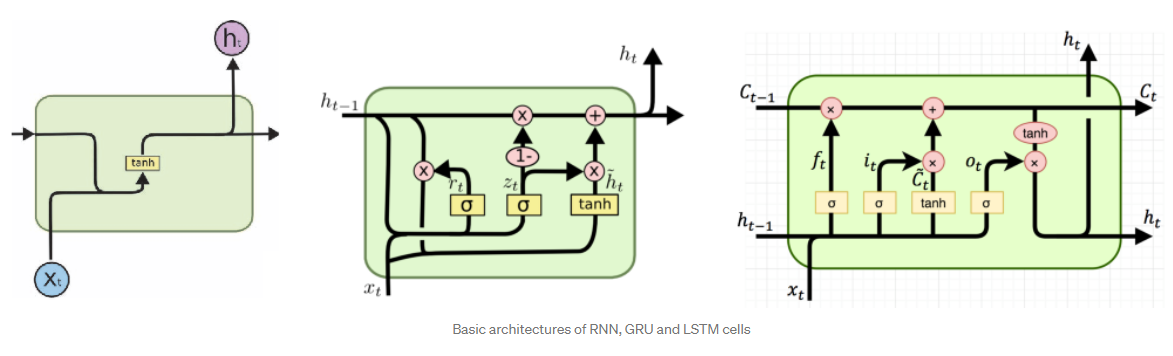

* LSTM을 간소화한 버전이지만 성능이 좋음
* LSTM과 달리 셀 상태를 계산하지 않고 은닉 상태 하나만 포함하고 있음
* GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀이 3개 들어있음
* 2개의 셀은 시그모이드 함수를 사용하고, 1개는 tanh 함수를 사용함

---


* Wz를 사용하는 셀의 출력이 은닉 상태에 바로 곱해져 삭제 게이트의 역할을 수행함
* 이 출력을 1에서 뺀 다음 Wg를 사용하는 셀의 출력에 곱함 -> 입력되는 정보 제어
* Wr을 사용하는 셀에서 출력된 값은 Wg 셀이 사용할 은닉 상태에 곱해져 Wg 셀의 은닉 상태가 되어 Wg 셀이 사용할 은닉 상태의 정보 제어

---


* GRU 셀은 LSTM보다 가중치가 적기 때문에 계산량이 적지만 LSTM 못지않은 성능을 냄
* 마지막 출력값에 활성화함수를 적용하지 않음
* 학습할 파라미터가 더 적은 것이 장점